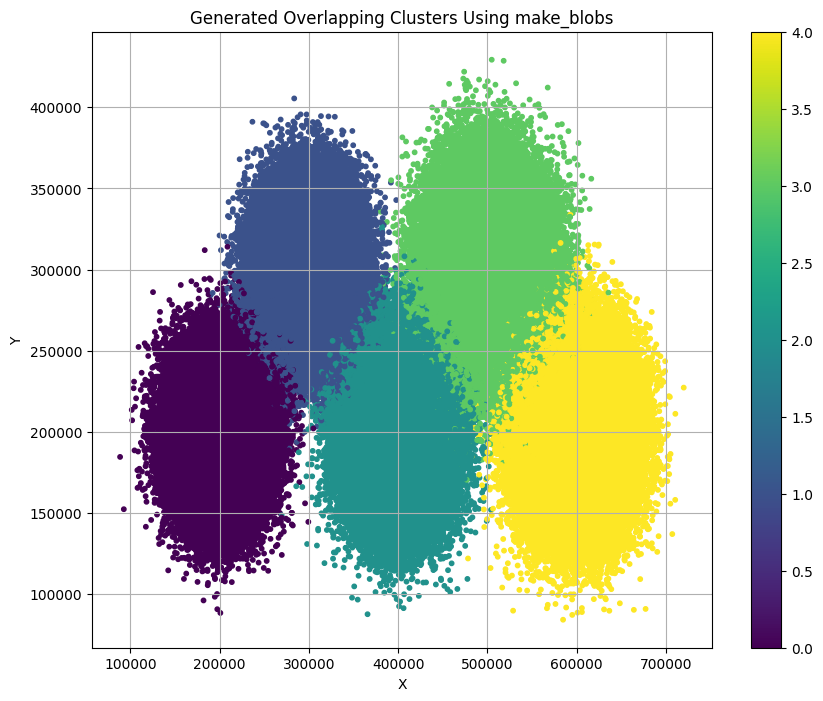

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns
import random

In [ ]:
# Define cluster centers (similar to means in your original setup)
centers = [
    [200000, 200000],  # Cluster 1
    [300000, 300000],  # Cluster 2
    [400000, 200000],  # Cluster 3
    [500000, 300000],  # Cluster 4
    [600000, 200000]   # Cluster 5
]

# Define standard deviations (similar to variance) for each cluster
cluster_std = [25000, 25000, 27000, 30000, 29000]  # These control spread of clusters

data, true_labels = make_blobs(n_samples=500000, centers=centers, cluster_std=cluster_std, random_state=42)

# Plotting the generated clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data[:, 0], data[:, 1], c=true_labels, cmap='viridis', s=10)
plt.colorbar(scatter)
plt.title("Generated Overlapping Clusters Using make_blobs")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [2]:
# Optimized initialization with vectorized operations for distance calculation
def initialize_centroids(data, k):
    n_samples, _ = data.shape
    centroids = []
    # Randomly select the first centroid
    centroids.append(data[random.randint(0, n_samples - 1)])

    # Array to store the minimum distances to the closest centroid
    distances = np.full(n_samples, np.inf)

    for _ in range(1, k):
        # Vectorized calculation of distances from all data points to the latest centroid
        new_distances = np.linalg.norm(data - centroids[-1], axis=1) ** 2

        # Update the minimum distances to the nearest centroid
        distances = np.minimum(distances, new_distances)

        # Normalize distances to get probabilities
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()

        # Select a new centroid based on cumulative probabilities
        centroids.append(data[np.searchsorted(cumulative_probabilities, r)])

    return np.array(centroids)

def compute_potential(data, labels, centroids):
    potential = 0.0
    for i, centroid in enumerate(centroids):
        potential += np.sum((data[labels == i] - centroid) ** 2)
    return potential

In [ ]:
def plot_normalized_potentials_box_hist(normalized_potentials):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Box plot of normalized potentials
    sns.boxplot(data=normalized_potentials, ax=axs[0], color='lightblue')
    axs[0].set_title("Box Plot of Normalized Potentials")
    axs[0].set_ylabel("Normalized Final Potential (Final / Optimal)")
    axs[0].axhline(y=1.0, color='red', linestyle='--', label="Optimal Potential (Normalized = 1)")
    axs[0].legend()

    # Histogram of normalized potentials
    sns.histplot(normalized_potentials, bins=15, kde=True, ax=axs[1], color='skyblue', edgecolor='black')
    axs[1].set_title("Histogram of Normalized Potentials")
    axs[1].set_xlabel("Normalized Final Potential (Final / Optimal)")
    axs[1].axvline(x=1.0, color='red', linestyle='--', label="Optimal Potential (Normalized = 1)")
    axs[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

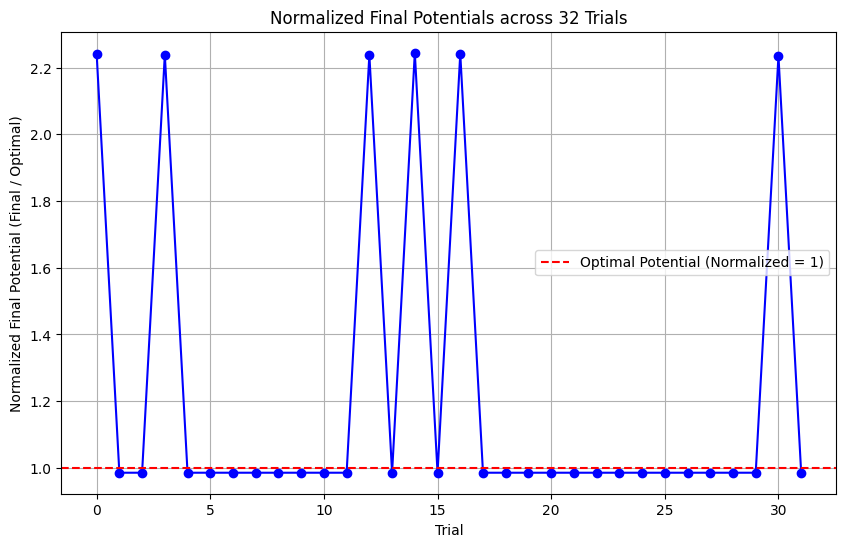

In [3]:
# Set the number of clusters
k = len(centers)
num_trials = 2 ** k  # Number of trials

optimal_potential = compute_potential(data, true_labels, centers)
def run_kmeans_and_compute_potential(data, k):
    # Initialize centroids using the vanilla K-means++ method
    initial_centroids = initialize_centroids(data, k)

    # Use custom centroids in KMeans
    kmeans = KMeans(n_clusters=k, init=initial_centroids, max_iter=300, n_init=1, random_state=None)
    kmeans.fit(data)
    
    final_centroids = kmeans.cluster_centers_
    final_labels = kmeans.labels_
    final_potential = compute_potential(data, final_labels, final_centroids)
    
    return final_potential

# Run 2^k trials and store the final potentials
final_potentials = []
for trial in range(num_trials):
    final_potential = run_kmeans_and_compute_potential(data, k)
    final_potentials.append(final_potential)

# Normalize the final potentials by dividing them by the optimal potential
normalized_potentials = [fp / optimal_potential for fp in final_potentials]

# Plot the normalized final potentials
plt.figure(figsize=(10, 6))
plt.plot(range(num_trials), normalized_potentials, marker='o', linestyle='-', color='blue')
plt.axhline(y=1.0, color='red', linestyle='--', label="Optimal Potential (Normalized = 1)")
plt.title(f"Normalized Final Potentials across {num_trials} Trials")
plt.xlabel("Trial")
plt.ylabel("Normalized Final Potential (Final / Optimal)")
plt.legend()
plt.grid(True)
plt.show()